# Explore VAE on SSP data

The notebook demonstrates the process of exploring a variational auto-encoder (VAE) model trained on Shared Socioeconomic Pathways (SSPs) data from CMIP6. The process involves various steps, including model and data loading, analysis of the latent space, model output generation, and reconstruction in grid space. The key steps and components involved are outlined as follows:

1. The configuration parameters of the model are loaded from the `LOG_DIR` folder.

2. The VAE model consists of four components: _encoder_, _latent sampling_, _decoder_, and a _second decoder for prediction_. Separate model instances are created for each component:
    * _Encoder_: The encoder takes a sample `x` and returns the mean `z_mean` and logarithmic variance `z_log_var` of the latent variable `z`.
    * _Latent Sampling_: The latent sampling takes `z_mean` and `z_log_var` as inputs and generates a random latent sample `z`.
    * _Decoder_: The decoder reconstructs the input `x` by taking the latent sample `z` and producing the decoded output `y`. The decoding is done backward in time, maintaining the input order.
   * _Decoder for Prediction_: The second decoder also takes the latent sample `z` but generates a forward-time prediction output.
   
3. The model weights from the training process are loaded from the `LOG_DIR` folder.

4. CMIP data is loaded from netCDF files, with different variables stacked along the channel axis.

5. Forcing data is loaded from a CSV file used for model training. Additional forcing data is loaded from a second CSV file, which will be used as a new trajectory of the condition for the decoder and prediction.

6. The `encoder` and `decoder` properties are explored. KL divergence, histograms, and temporal behavior of the latent variables are analyzed. Invariance of the latent space with respect to forcing is tested.

7. The model outputs are obtained for the CMIP data and the new forcing data. The outputs of the `decoder` and `prediction` are collected separately and aligned with the target month. The VAE output is restricted to specific time lags for reducing file size.

8. The model output is projected into grid space by forming the scalar product with the EOFs (Empirical Orthogonal Functions).The corresponding climatological mean fields are loaded and added to obtain absolute values.

9. Selected model runs with the highest KL divergence are used to form the ensemble forecast. Various ensemble statistics are exported as as netCDF files in the specified `EXPORT_DIR` folder.

## Imports

In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import os
from types import SimpleNamespace

import numpy as np
import pandas as pd
import tensorflow.keras as ks
import yaml
from IPython.display import display
from matplotlib import dates
from matplotlib import pyplot as plt
from matplotlib import ticker
from scipy import signal

In [3]:
from tensorflow import get_logger
from tensorflow.compat.v1 import disable_eager_execution, disable_v2_behavior

get_logger().setLevel('ERROR')
disable_eager_execution()
disable_v2_behavior()

In [4]:
from VAE import generators, models
from VAE.utils import fileio
from VAE.utils import plot as vplt

In [44]:
FIGWIDTH = 12
VERBOSE = 1
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 75
np.set_printoptions(formatter={'float_kind': lambda x: f'{x: .3f}'}, linewidth=120)

## Parameters

We load the configuration from the the folder `LOG_DIR`. The model output is written to netCDF files in the folder given in `EXPORT_DIR`.

In [6]:
EPOCH = 20
LOG_DIR = r'logs/2023-05-30T18.58'
MODEL_FILE = f'model.{EPOCH:02d}.h5'
EXPORT_DIR = r'results/2023-05-30T18.58'

In [7]:
print('LOG_DIR    :', LOG_DIR)
print('MODEL_FILE :', MODEL_FILE)
print('EXPORT_DIR :', EXPORT_DIR)

LOG_DIR    : logs/2023-05-30T18.58
MODEL_FILE : model.20.h5
EXPORT_DIR : results/2023-05-30T18.58


First let's load the parameters from the model training in `trainer_config.yaml`.

In [8]:
fn = os.path.join(LOG_DIR, 'trainer_config.yaml')
with open(fn, 'r') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

print('Load configuration from:', os.path.normpath(fn))

assert params['model'].get('__version__') == models.__version__, 'Model version mismatch.'
assert params['fit_generator'].get('__version__') == generators.__version__, 'Generator version mismatch.'

params = SimpleNamespace(**params)

Load configuration from: logs\2023-05-30T18.58\trainer_config.yaml


Make some modifications to the parameters

In [9]:
params.model['beta'] = 1.  # no beta scheduler needed at inference time
params.fit_generator['shuffle'] = False  # do not shuffle samples
# params.fit_generator['repeat_samples'] = 1

In [10]:
# print(yaml.dump(params.__dict__))

## Model

The VAE model consists of four components: encoder, latent sampling, decoder, and a second decoder for prediction. Separate model instances are created for each component.

### Encoder

The encoder takes a sample `x` and returns `z_mean` and `z_log_var`:

In [11]:
encoder = models.Encoder(**params.model, name='encoder')

### Latent sampling

The latent sampling takes the two inputs `z_mean` and `z_log_var` and returns a set of `set_size=1` random latent sample `z`:

In [12]:
latent_sampling = models.LatentSampling(**params.model, name='latent')

### Decoder

The decoder, finally, takes a latent sample `z` and returns the decoded output `y` to reconstruct `x`. The decoding works backward in time and we set `output_reverse=True` so that the order of decoder output matches the input to the encoder.

In [13]:
decoder = models.Decoder(output_shape=params.model.get('input_shape'),
                         decoder_blocks=params.model.get('encoder_blocks'),
                         output_reverse=True,
                         **params.model,
                         name='decoder')

### Decoder for prediction

Like the decoder, the second decoder takes the same latent sample `z` and it's output will provide the prediction. In contrast to the `decoder`, we set `output_reverse=False` so that the output of `prediction` is forward in time.

In [14]:
prediction = models.Decoder(output_shape=params.model.get('prediction_shape'),
                            output_reverse=False,
                            **{
                                'decoder_blocks': params.model.get('encoder_blocks'),
                                **params.model,
                                **params.prediction
                            },
                            name='prediction')

### Full model

Now that we have the four components, we a ready to create the full model.

In [15]:
model = models.VAEp(encoder, decoder, latent_sampling, prediction, **params.model)

Let's plot the model

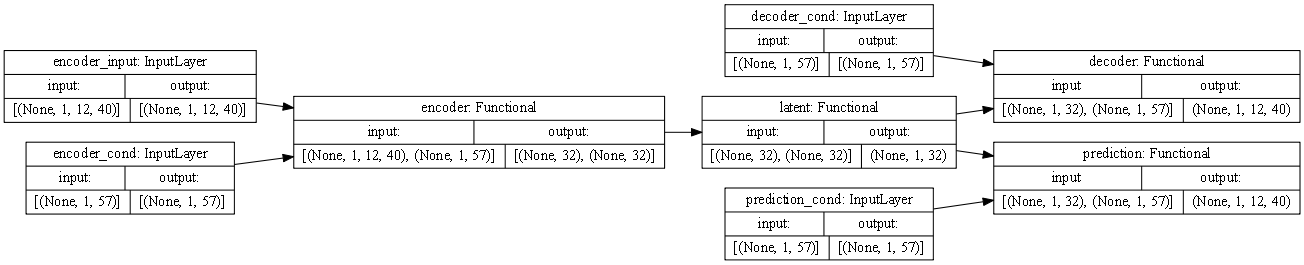

In [16]:
ks.utils.plot_model(model, show_shapes=True, dpi=75, rankdir='LR')

and summarize the model

In [17]:
model.summary(line_length=120)

Model: "mVAEp"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
encoder_input (InputLayer)             [(None, 1, 12, 40)]        0                                                     
________________________________________________________________________________________________________________________
encoder_cond (InputLayer)              [(None, 1, 57)]            0                                                     
________________________________________________________________________________________________________________________
encoder (Functional)                   [(None, 32), (None, 32)]   185340        encoder_input[0][0]                     
                                                                                encoder_cond[0][0]                      
_________________

### Load model weights

We load the model weights from the training.

In [18]:
fn = os.path.join(LOG_DIR, MODEL_FILE)
model.load_weights(fn, by_name=True)
print('Load model weights from:', os.path.normpath(fn))

Load model weights from: logs\2023-05-30T18.58\model.20.h5


## Data

### CMIP data

We load the netCDF files of CMIP data.

In [19]:
_variables, _dimensions, _attributes = fileio.read_netcdf_multi(**params.data, num2date=True)

data\cmip6\ssp\pr\pcs\pcs*.nc  : 100 file(s) found.
data\cmip6\ssp\tos\pcs\pcs*.nc : 100 file(s) found.
200/200 [==============================] - 20s 101ms/file


We group the netCDF files and their variables by the global attributes `source_id` + `experiment_id`. The attribute `source_id` refers to the model name (e.g. `ACCESS-CM2`) and the attribute `experiment_id` to the experiment (e.g. `ssp126`).

In [20]:
variables = {}
dimensions = {}
attributes = {}

key1 = 'source_id'
key2 = 'experiment_id'
for dataset_name, values in _variables.items():
    target_key = (
        _attributes[dataset_name]['.'][key1],
        _attributes[dataset_name]['.'][key2],
    )

    variables.setdefault(target_key, {})
    dimensions.setdefault(target_key, {})
    attributes.setdefault(target_key, {})

    variables[target_key] |= {k: pd.DataFrame(v, index=_dimensions[dataset_name]['time']) for k, v in values.items()}
    dimensions[target_key] |= {k: _dimensions[dataset_name] for k in values.keys()}
    attributes[target_key] |= {k: _attributes[dataset_name] for k in values.keys()}

We make a few tests to check the integrity of the data.

In [21]:
variable_names = {tuple(val.keys()) for val in variables.values()}
if len(variable_names) > 1:
    raise ValueError(f'More than one variable combination found: {variable_names}')
else:
    variable_names, *_ = variable_names
    print('\N{check mark} One variable combination found:', variable_names)

variable_channels = {tuple(v.shape[-1] for v in val.values()) for val in variables.values()}
if len(variable_channels) > 1:
    raise ValueError(f'More than one channel combination found: {variable_channels}')
else:
    variable_channels, *_ = variable_channels
    print('\N{check mark} One channel combination found:', variable_channels)

✓ One variable combination found: ('pr', 'tos')
✓ One channel combination found: (20, 20)


The following table summarizes the models and their different runs.

In [22]:
print('Number of model runs found :', len(variables))
df = pd.crosstab(*list(zip(*list(variables.keys()))), rownames=[key1], colnames=[key2])
df.loc['--- Total ---'] = df.sum(axis=0)
display(df.replace(0, ''))

Number of model runs found : 100


experiment_id   ssp126 ssp245 ssp370 ssp585
source_id                                  
ACCESS-CM2           1      1      1      1
ACCESS-ESM1-5        1      1      1      1
BCC-CSM2-MR          1      1      1      1
CAMS-CSM1-0          1      1      1      1
CAS-ESM2-0           1      1      1      1
CESM2-WACCM          1      1      1      1
CMCC-CM2-SR5         1      1      1      1
CMCC-ESM2            1      1      1      1
CanESM5              1      1      1      1
CanESM5-1            1      1      1      1
E3SM-1-0                                  1
E3SM-1-1                                  1
E3SM-1-1-ECA                              1
FGOALS-f3-L          1      1      1      1
FGOALS-g3            1      1      1      1
GFDL-ESM4            1      1      1      1
IITM-ESM             1      1      1      1
INM-CM4-8            1      1      1      1
INM-CM5-0            1      1      1      1
IPSL-CM5A2-INCA      1             1       
IPSL-CM6A-LR         1      1      1      1
KACE-1-0-G           1      1      1      1
MIROC6               1      1      1      1
MPI-ESM1-2-LR        1      1      1      1
MRI-ESM2-0           1      1      1      1
NESM3                1      1             1
NorESM2-LM           1      1      1      1
NorESM2-MM           1      1      1      1
--- Total ---       25     24     24     27

#### Plot data

In the following plot, we compare the different CMIP datasets.

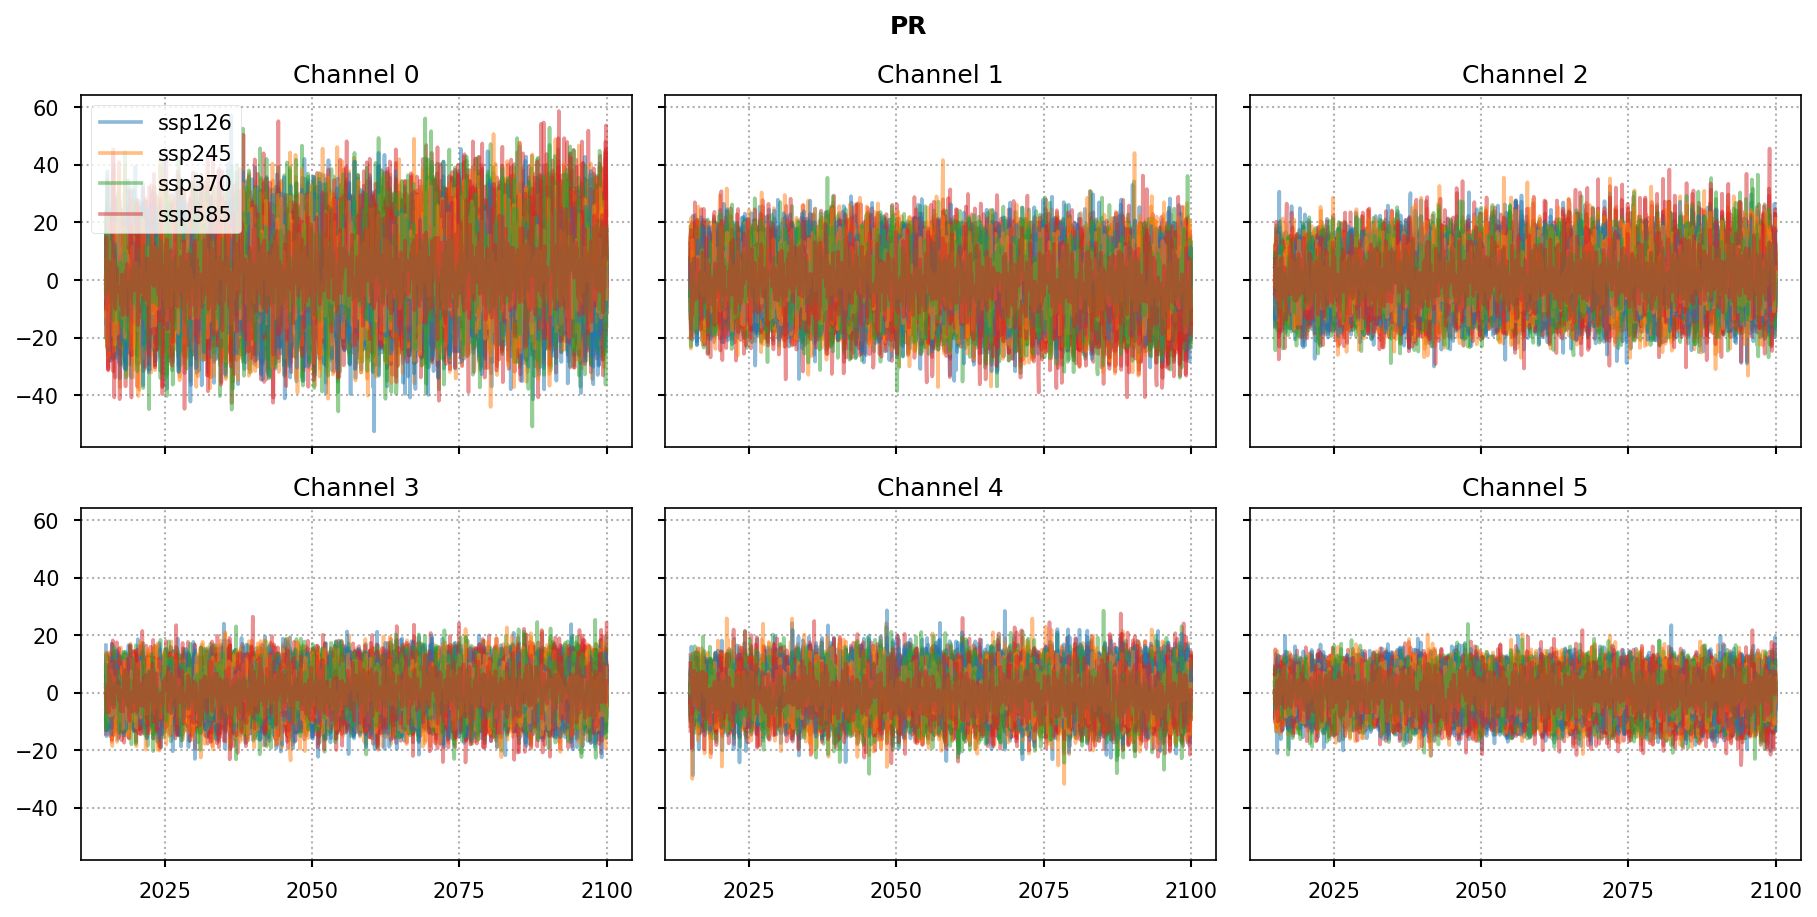

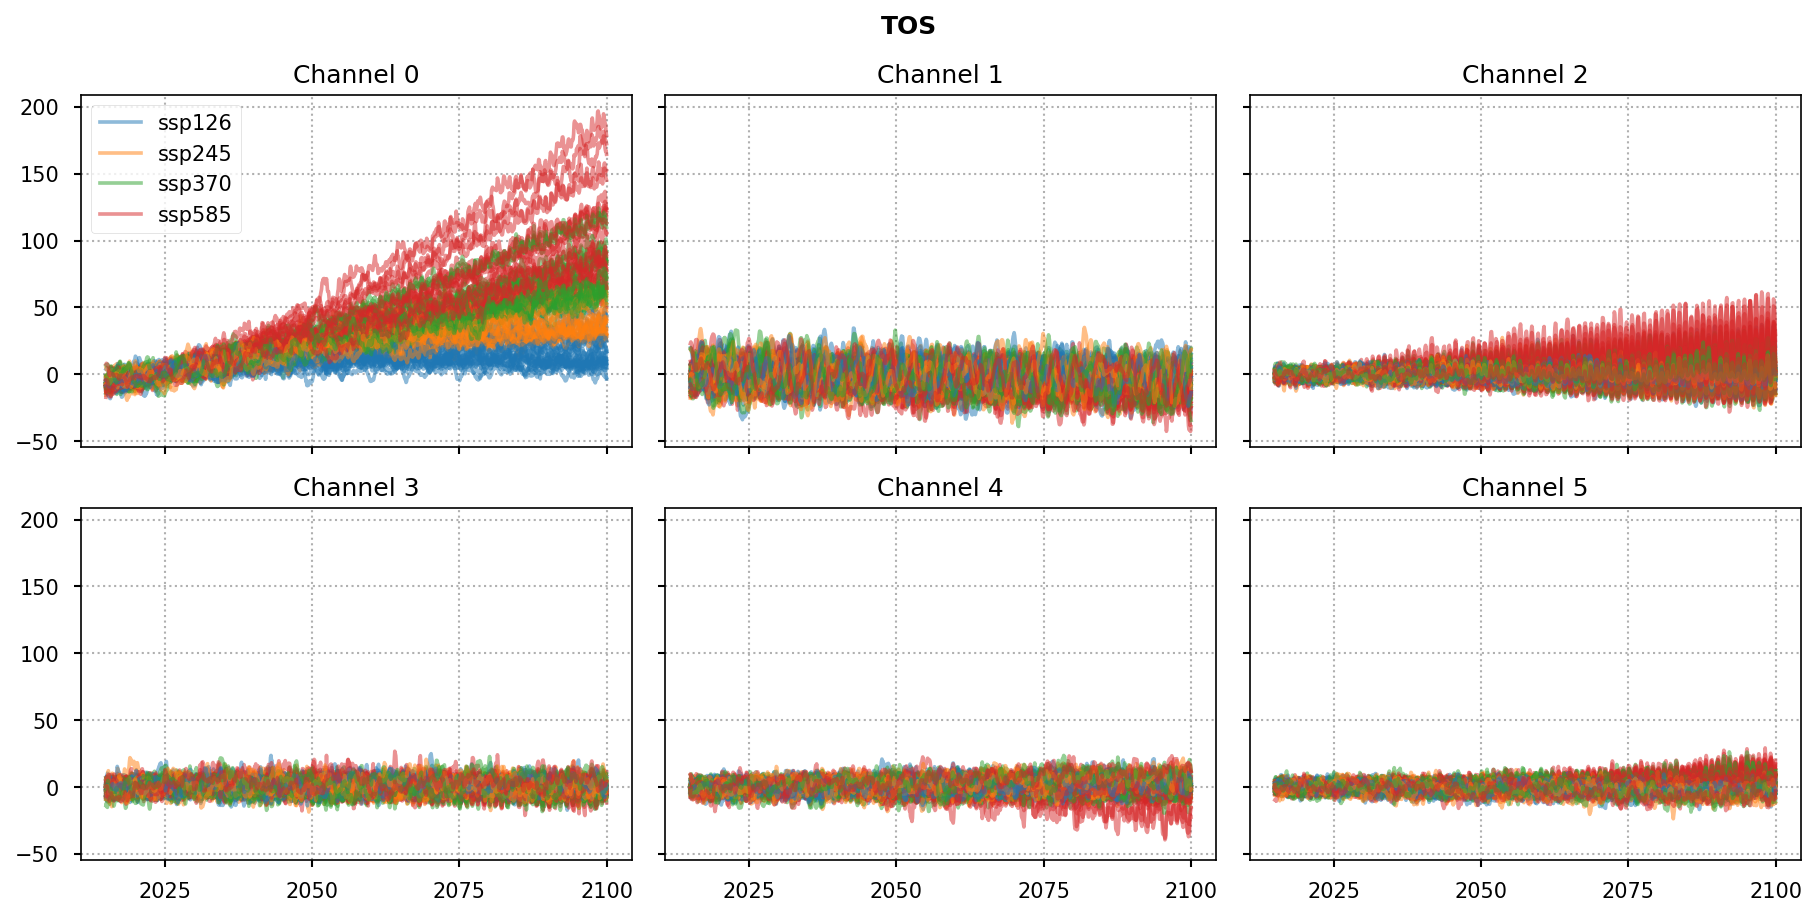

In [45]:
cols = 3
rows = 2

dataset_names = list(variables.keys())
_, first_idx, color_idx = np.unique([dataset_name[1] for dataset_name in dataset_names],
                                    return_index=True,
                                    return_inverse=True)

cm = plt.cm.get_cmap('tab10', 10)
color_dict = {name: cm(idx) for name, idx in zip(dataset_names, color_idx)}

for variable_name in variable_names:
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(FIGWIDTH, 3 * rows), squeeze=False)
    fig.suptitle(variable_name.upper(), fontweight='bold')
    for idx, dataset_name in enumerate(dataset_names):
        for channel, (ax, values) in enumerate(zip(axs.flat, variables[dataset_name][variable_name].values.T)):
            label = dataset_name[1] if idx in first_idx else None
            ax.plot(variables[dataset_name][variable_name].index,
                    values,
                    color=color_dict[dataset_name],
                    label=label,
                    alpha=0.5)

            ax.set_title(f'Channel {channel}')
            ax.grid(visible=True, linestyle=':')
            locator = dates.YearLocator(25)
            ax.xaxis.set_major_formatter(dates.ConciseDateFormatter(locator))
            ax.xaxis.set_major_locator(locator)

    axs.flat[0].legend()

#### Stack variables

The variables are stack along the last axis, the channels. We add a leading singleton dimension to `dataset` for `set_size=1`.

In [89]:
dataset_names_rand = list(variables.keys())

In [47]:
data_stack = [
    pd.concat([variables[dataset_name][variable_name] for variable_name in variable_names], axis=1, join='inner')
    for dataset_name in dataset_names_rand
]

time = [d.index for d in data_stack]
dataset = [d.to_numpy()[None, ...] for d in data_stack]

For the training, the dataset was furthermore split into one set for model training and one set for model validation. At inference time, we keep the entier dataset in order to generate results for all CMIP runs.

In [48]:
validation_split = 0
print('Size of training dataset   :', len(dataset[:validation_split]))
print('Size of validation dataset :', len(dataset[validation_split:]))

Size of training dataset   : 0
Size of validation dataset : 100


### Forcing data

#### SSP forcings

We load the forcing data from a csv file used to train the model. The first column is considered as the date and the remaining columns as the corresponding forcing data. The column header of the forcing data must match the `experiment_id`.

In [49]:
filename = params.forcing['filename']
forcing_df = pd.read_csv(filename, index_col=0, parse_dates=True)
print('Load forcing data from:', os.path.relpath(filename))
display(forcing_df)

Load forcing data from: data\cmip6\ssp\forcings\SSP_CMIP6_world_C02.csv


ssp126    ssp245    ssp370     ssp585
time                                               
2000-01-01  31652.73  31648.76  31648.76   31652.73
2010-01-01  36452.73  36448.76  36448.76   36452.73
2015-01-01  39152.73  39148.76  39148.76   39152.73
2020-01-01  39804.01  40647.53  44808.04   43712.35
2030-01-01  34734.42  43476.06  52847.36   55296.58
2040-01-01  26509.18  44252.90  58497.97   68775.70
2050-01-01  17963.54  43462.19  62904.06   83298.22
2060-01-01  10527.98  40196.48  66568.37  100338.61
2070-01-01   4476.33  35235.43  70041.98  116805.25
2080-01-01  -3285.04  26838.37  73405.23  129647.04
2090-01-01  -8385.18  16324.39  77799.05  130576.24
2100-01-01  -8617.79   9682.86  82725.83  126287.31

The forcing data is interpolated so that it can be resampled at the time points of the CMIP data.

In [50]:
forcing_df_daily = forcing_df.asfreq('D').interpolate(method='akima')

Instead of providing only the current value of the forcing as condition, we can optionally provide past values as well. The parameter `input_length` in `params.forcing` determines the number of past values (in years) that will be provided as condition.

In [51]:
scale = params.forcing.get('scale', 1)
input_length = params.forcing.get('input_length', 1)

forcing_data = [
    np.stack([
        forcing_df_daily[experiment_id].reindex(t - pd.DateOffset(years=years), method='nearest').to_numpy() * scale
        for years in range(input_length)
    ],
             axis=1) for t, (_, experiment_id) in zip(time, dataset_names_rand)
]

#### New forcings

We furthermore load forcing data from a second csv file that will be used as condition for `decoder` and `prediction`. The first column is considered as the date and the second column as the corresponding forcing data. The new forcing data is the same for all dataset, i.e. the same for different `experiment_id`.

In [52]:
filename2 = r'data\cmip6\ssp\forcings\SSP_jumps_world_C02.csv'

forcing2_df = pd.read_csv(filename2, index_col=0, parse_dates=True)
print('Load forcing data from:', os.path.relpath(filename2))
display(forcing2_df)

Load forcing data from: data\cmip6\ssp\forcings\SSP_jumps_world_C02.csv


ssp_jumps
time                 
2000-01-01   31648.76
2010-01-01   36448.76
2015-01-01   44808.04
2020-01-01   44808.04
2030-01-01   44808.04
2039-01-01   44808.04
2040-01-01   54252.90
2050-01-01   54252.90
2060-01-01   54252.90
2069-01-01   54252.90
2070-01-01   64252.90
2080-01-01   64252.90
2090-01-01   64252.90
2100-01-01   64252.90

The new forcing data is likewise interpolated and embedded as the original forcings.

In [53]:
forcing2_df_daily = forcing2_df.asfreq('D').interpolate(method='akima')
forcing2_name, *_ = forcing2_df_daily.keys()

forcing2_data = [
    np.stack([
        forcing2_df_daily[forcing2_name].reindex(t - pd.DateOffset(years=years), method='nearest').to_numpy() * scale
        for years in range(input_length)
    ],
             axis=1) for t in time
]

#### Compare forcings

We compare the original SSP forcings with the modified forcing.

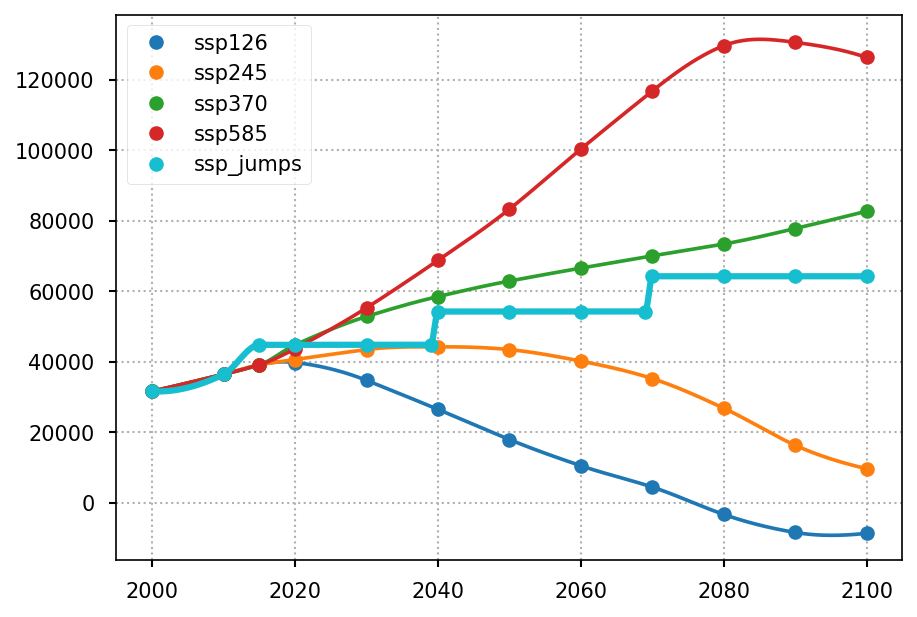

In [56]:
fig, ax = plt.subplots(1, figsize=(FIGWIDTH / 2, FIGWIDTH / 3))
for n, (forcing_name, val) in enumerate(forcing_df.items()):
    ax.plot(val, 'o', color=cm(n), label=forcing_name)
    ax.plot(forcing_df_daily[forcing_name], '-', color=cm(n))

new_color = cm(len(forcing_df) + 1)
for n, (forcing_name, val) in enumerate(forcing2_df.items()):
    ax.plot(val, 'o', color=new_color, label=forcing_name)
    ax.plot(forcing2_df_daily[forcing_name], '-', color=new_color, linewidth=3)

ax.legend()
ax.grid(linestyle=':')

## Prepare generator

### Validation generator

The validation generator takes the full set of CMIP data.

During training, the same CO2 concentration data was provided as condition to the encoder and decoder corresponding to the input and target data they were trained on. During inference, here, different values of CO2 concentration data are provided as input to the decoder. This allows the VAE to generate forecasts for different CO2 concentration scenarios while sampling from the latent space.

In [57]:
month = [t.to_numpy().astype('datetime64[M]').astype(int) for t in time]
_, model_index = np.unique([dataset_name[0] for dataset_name in dataset_names_rand], return_inverse=True)

In [58]:
val_gen = generators.FitGenerator(dataset[validation_split:],
                                  **params.fit_generator,
                                  time=month[validation_split:],
                                  ensemble_index=model_index[validation_split:],
                                  condition={
                                      'encoder': forcing_data[validation_split:],
                                      'decoder': forcing2_data[validation_split:]
                                  })
val_gen.summary()

Number of datasets : 100
Total data size    : 4,079,520
Total data length  : 101,988
Strides            : 1
Number of samples  : 99,688
Batch size         : 128
Number of batches  : 779
Sample repetitions : 5
Actual batch size  : 128 * 5 = 640
Shuffle            : False
Ensemble condition
  size : 29
  type : index
Input channels     : all
Predicted channels : all
Output shapes
  inputs
    encoder_input    : (640, 1, 12, 40)
    encoder_cond     : (640, 1, 57)
    decoder_cond     : (640, 1, 57)
    prediction_cond  : (640, 1, 57)
  targets
    decoder          : (640, 1, 12, 40)
    prediction       : (640, 1, 12, 40)


## Latent space

The module `VAE.utils.plot` provides multiple functions to plot and analyze properties of the `encoder` and the `decoder`. First let's start with the `encoder` and explore properties of the latent space.

### KL divergence

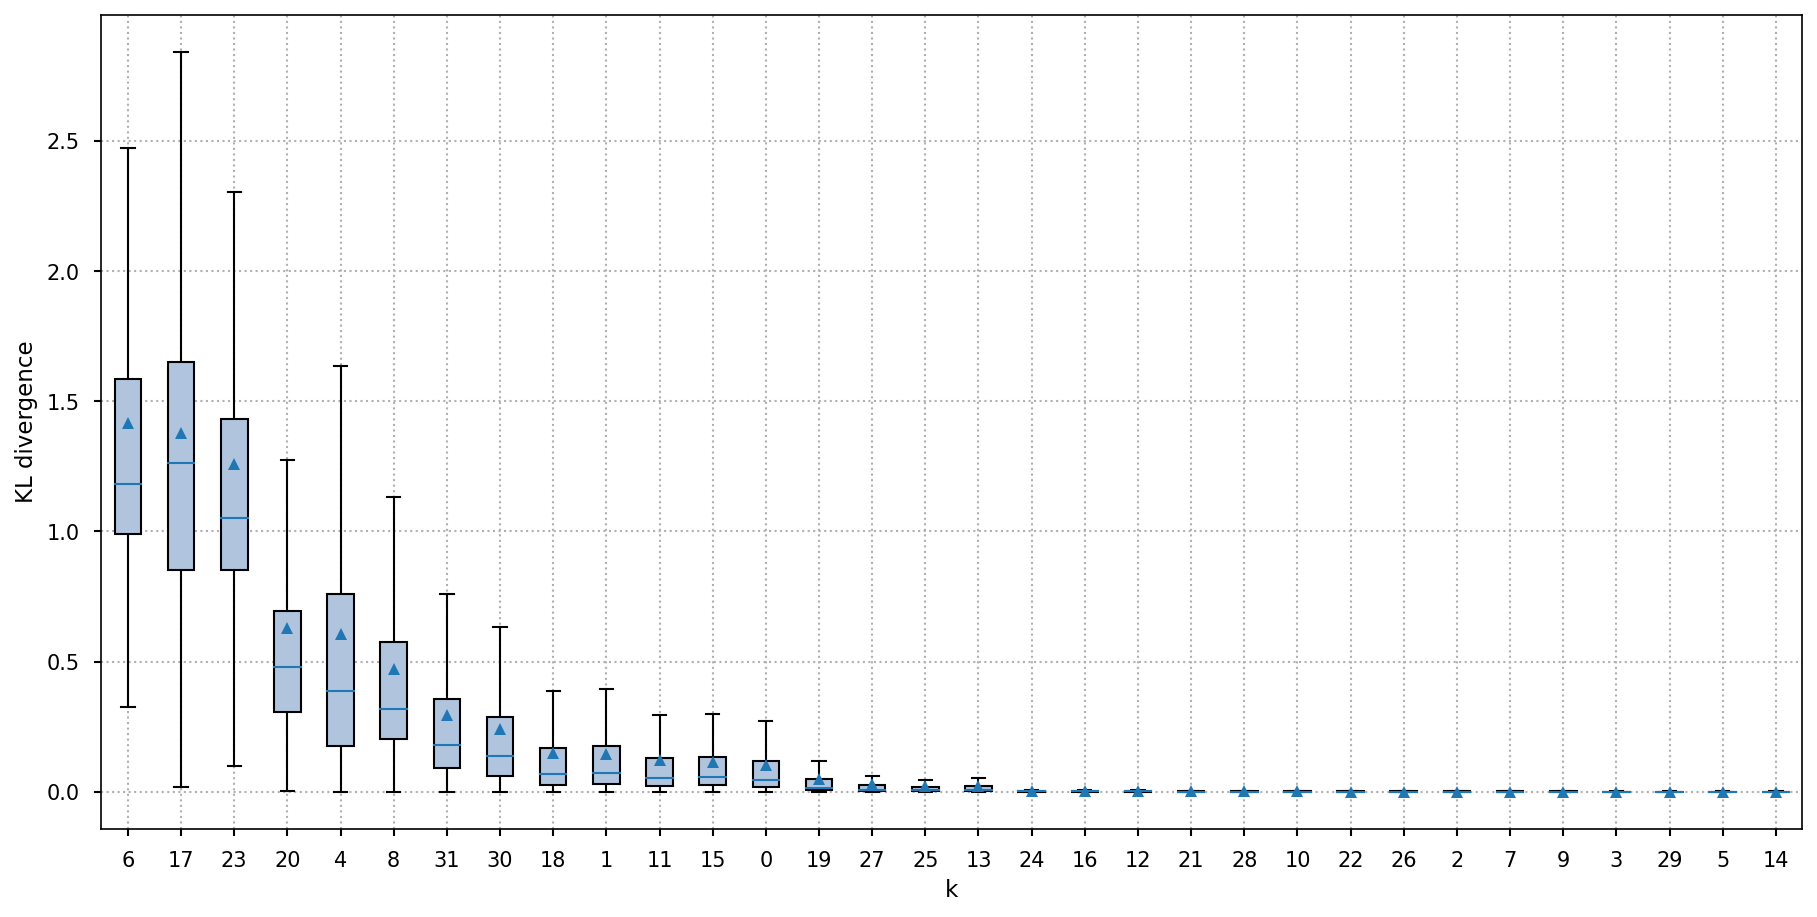

In [61]:
fig = plt.figure(0, figsize=(FIGWIDTH, 6))
fig, ax, z_order, kl_div = vplt.encoder_boxplot(encoder, val_gen, plottype='kl', name=0, verbose=VERBOSE)

The plot shows the KL divergence of the latent variables for each of the latent dimension separately. The dimensions are sorted in descending order of the KL divergence. Latent dimensions with a high KL divergence are more important for the reconstruction with the decoder. Latent dimensions that have a KL divergence close to zero are unused dimensions; i.e. they are practically not important for the reconstruction.

A good property is when we observe a separation into a few important and vanishing (zero KL) dimensions, which means that the VAE is operating in a so-called __polarized regime__. This avoids overfitting with too many latent dimensions.

In [62]:
active_units = np.sum(np.mean(kl_div, axis=0) > 0.1)
print('Number of active units:', active_units)

Number of active units: 13


### Temporal behavior

Next, we analyze the temporal behavior of the latent variables. In doing so, we obtain the latent variables of the validation dataset.

In [63]:
z_mean, z_log_var = encoder.predict(val_gen, verbose=VERBOSE)
z_sample = latent_sampling.predict([z_mean, z_log_var])
z_sample = np.squeeze(z_sample)

The latent variables are split into the different model runs.

In [64]:
val_gen_splits = np.cumsum([(len(t) - val_gen.input_length - val_gen.prediction_length + 1) * val_gen.repeat_samples
                            for t in time[validation_split:]][:-1])

z_sample_list = np.split(z_sample, val_gen_splits, axis=0)

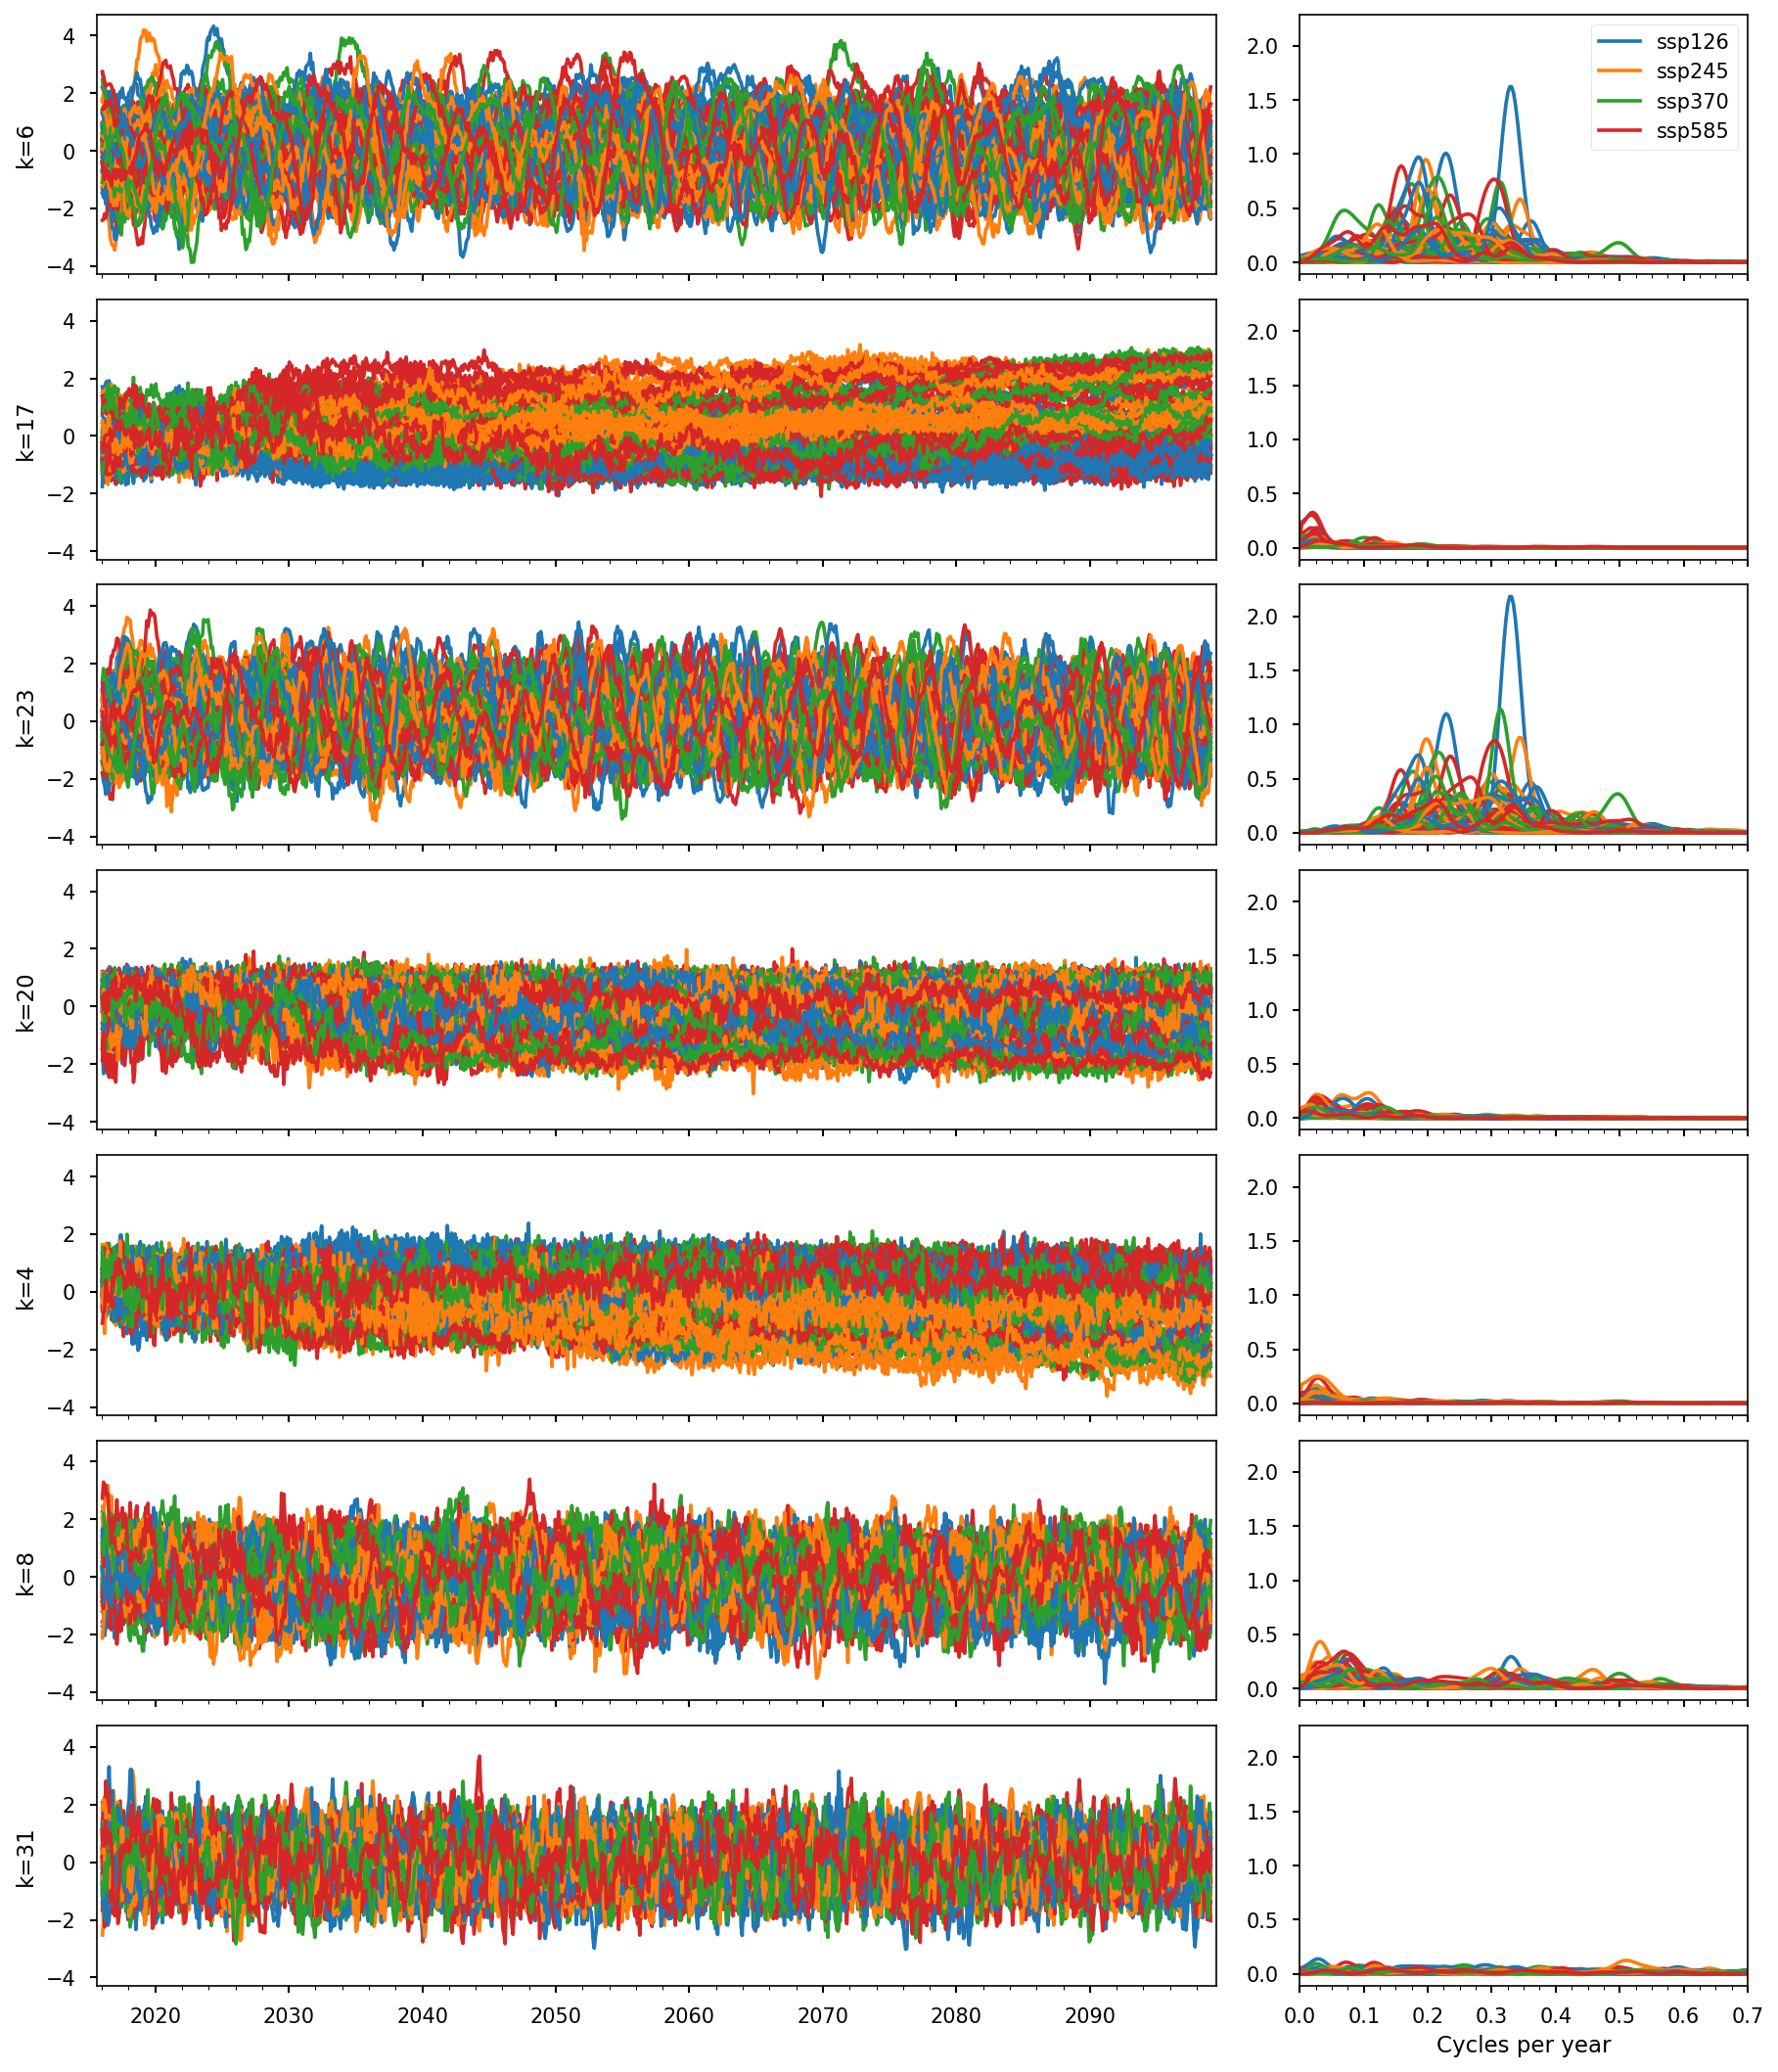

In [88]:
rows = 7
fig, axs = plt.subplots(rows,
                        2,
                        figsize=(FIGWIDTH, 2 * rows),
                        sharex='col',
                        sharey='col',
                        squeeze=False,
                        gridspec_kw={
                            'width_ratios': [2.5, 1],
                            'wspace': 0.1
                        })

r = val_gen.repeat_samples
nfft = 2**12
fs = 12

for idx, (t, z,
          dataset_name) in enumerate(zip(time[validation_split:], z_sample_list,
                                         dataset_names_rand[validation_split:])):
    label = dataset_name[1] if idx in first_idx else None
    for (lax, rax), k in zip(axs, z_order):
        lax.plot(t[val_gen.input_length:-val_gen.prediction_length + 1],
                 z[:, k].reshape(-1, r).mean(axis=-1),
                 color=color_dict[dataset_name])
        lax.set_ylabel(f'{k=}')
        lax.grid(axis='x', linestyle=':')

        f, pxx = signal.welch(z[:, k].reshape(-1, r).mean(axis=-1),
                              nfft=nfft,
                              fs=fs,
                              nperseg=512,
                              axis=0,
                              scaling='spectrum')
        rax.plot(f, pxx, color=color_dict[dataset_name], label=label)

axs[0, 1].legend()
lax.margins(x=0.005)
locator = dates.YearLocator(10)
ax.xaxis.set_major_locator(locator)
lax.xaxis.set_major_formatter(dates.ConciseDateFormatter(locator))
lax.xaxis.set_minor_locator(dates.YearLocator(2))

rax.set_xlim((0, 0.7))
rax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
rax.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
_ = rax.set_xlabel('Cycles per year')

The plot shows the temporal dynamics of the latent variables and the corresponding power spectrum. The success of disentanglement can be seen in a clear spearation between different dynamics, e.g. different power spectra. In the leading three latent dimensions, we can identify a low-frequency component and an oscillatory pair. The oscillatory pair is characterized by similar power specra.

In [66]:
k_trend = getattr(params, '__notes__', {}).get('k_trend', z_order[0])
k_pair = getattr(params, '__notes__', {}).get('k_pair', z_order[[1, 2]])

### Test invariance of latent space wrt forcing

In the following, we test whether the leading latent dimensions are not specific to the different forcings. If this is the case, the VAE has learned a posterior that is invariant to the different forcings. This, in turn, is important if we want the output of the VAE to depend only on the forcings, while drawing a random sample from the posterior aggregrated over different forcings.

#### Forcing vs. low-frequency component

First we analyze the low-frequency component.

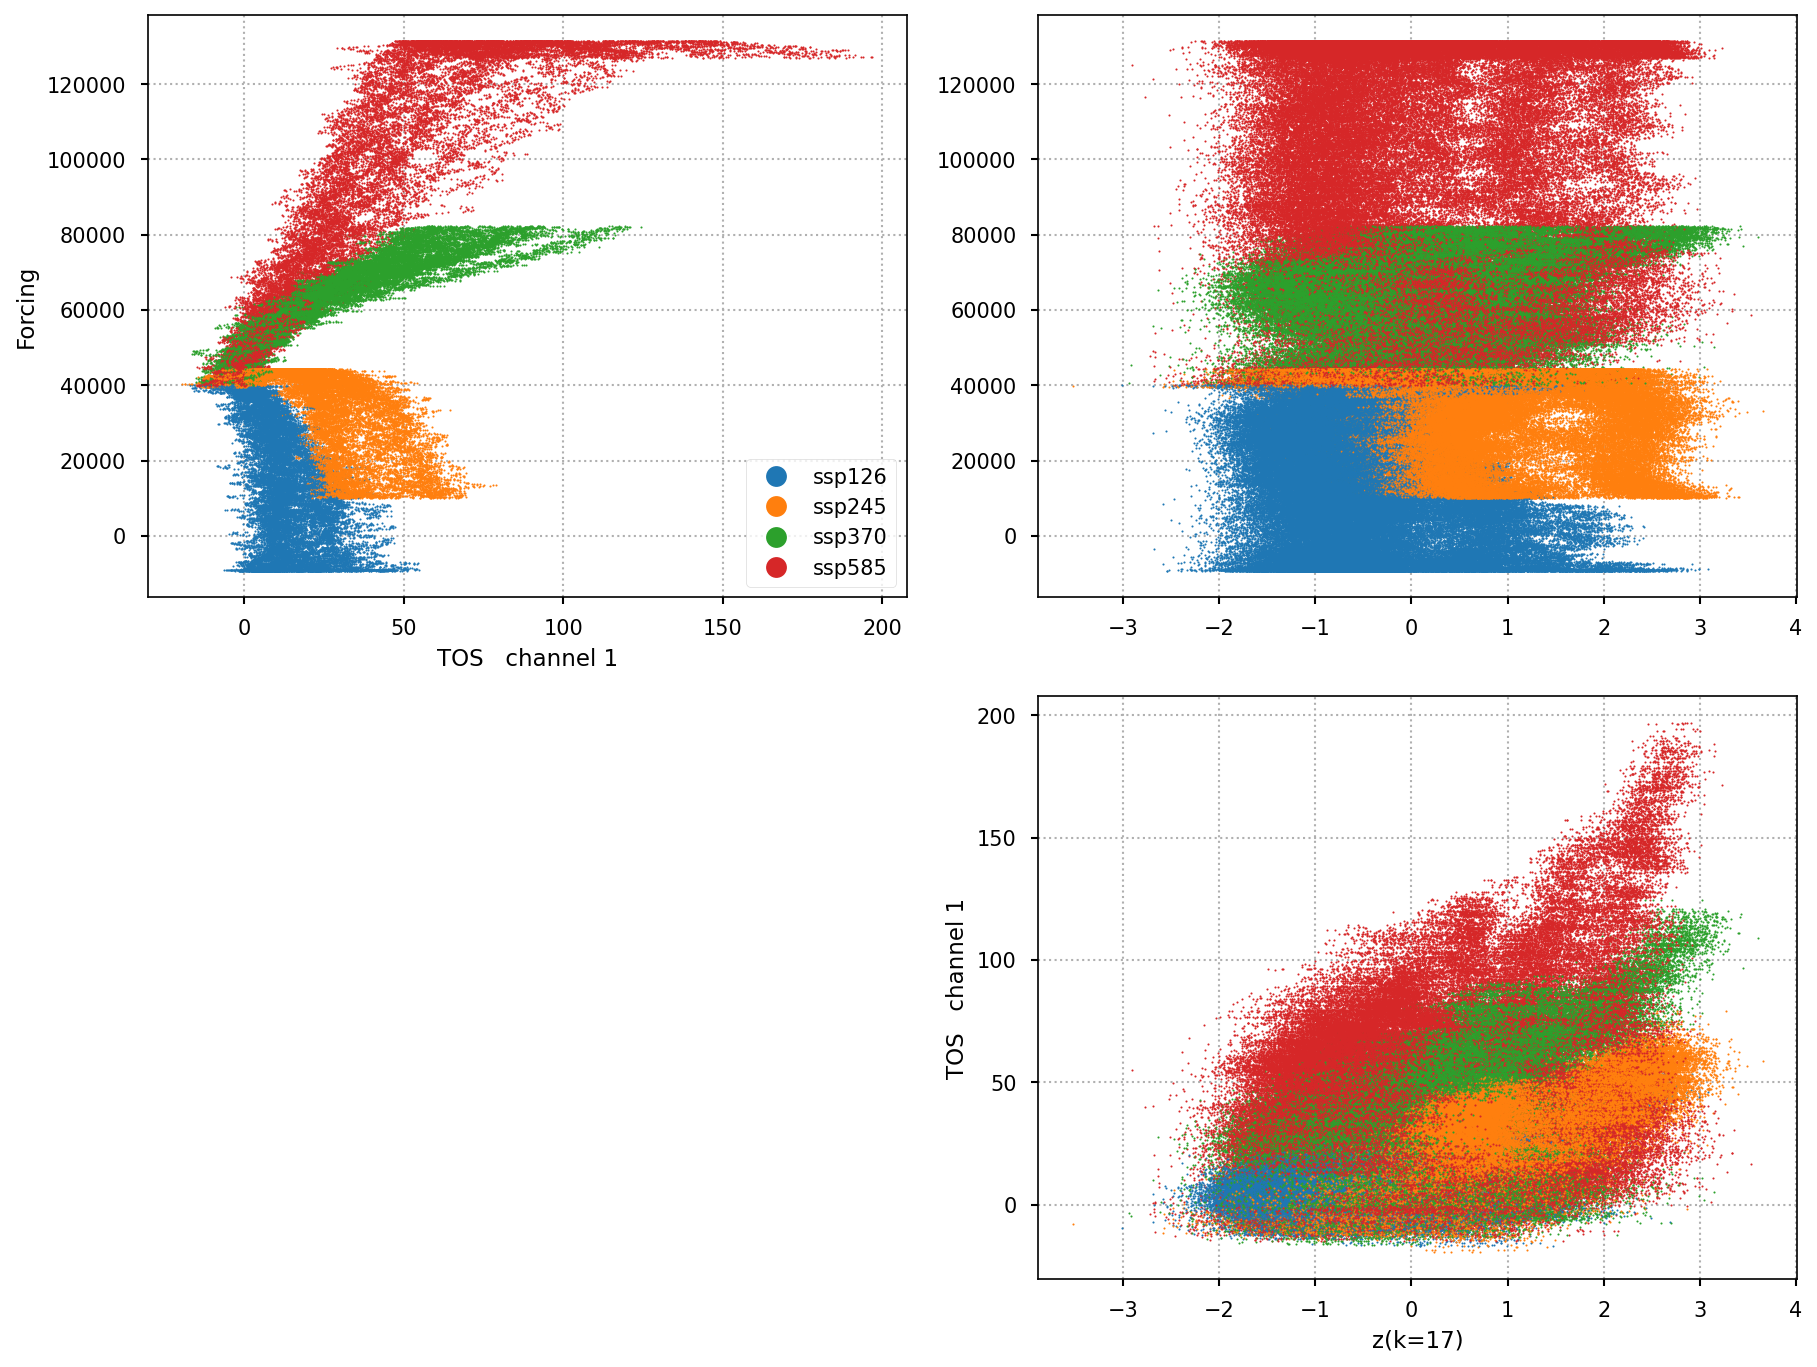

In [87]:
variable_name = variable_names[1]
k_pc = 0

fig, axs = plt.subplots(2, 2, figsize=(FIGWIDTH, FIGWIDTH * 0.75))
kw_args = dict(marker='.', markersize=2, linestyle='none')
for idx, (dataset_name, forcing,
          z) in enumerate(zip(dataset_names_rand[validation_split:], forcing_data[validation_split:], z_sample_list)):
    forcing = np.atleast_2d(forcing)[:, 0] / params.forcing.get('scale', 1)
    data = variables[dataset_name][variable_name].values
    label = dataset_name[1] if idx in first_idx else None
    axs[0, 0].plot(data[val_gen.input_length:-val_gen.prediction_length + 1, k_pc],
                   forcing[val_gen.input_length:-val_gen.prediction_length + 1],
                   color=color_dict[dataset_name],
                   label=label,
                   **kw_args)

    axs[0, 1].plot(z[:, k_trend].reshape(-1, r),
                   forcing[val_gen.input_length:-val_gen.prediction_length + 1],
                   color=color_dict[dataset_name],
                   **kw_args)

    axs[1, 1].plot(z[:, k_trend].reshape(-1, r),
                   data[val_gen.input_length:-val_gen.prediction_length + 1, k_pc],
                   color=color_dict[dataset_name],
                   **kw_args)

for ax in axs.flat:
    ax.grid(linestyle=':')
axs[1, 0].remove()

axs[0, 0].legend(markerscale=10, loc='lower right')
axs[0, 0].set_ylabel('Forcing')
axs[1, 1].set_xlabel(f'z(k={k_trend})')
axs[0, 0].set_xlabel(f'{variable_name.upper()}   channel {k_pc + 1}')
axs[1, 1].set_ylabel(f'{variable_name.upper()}   channel {k_pc + 1}')

invert = np.mean([z[-1, k_trend] for z in z_sample_list]) < 0
if invert:
    axs[0, 1].invert_xaxis()
    axs[1, 1].invert_xaxis()

In the upper left panel, we compare the forcing with the leading PC in the SST, i.e. the trend in the SST. There is clearly a strong relationship between the two. In the upper right panel, we compare the forcing with the low frequency component. We see that the distributions of the $z$ values have a strong overlap, indicating success of the VAE in learning an invariant representation of the low-frequency dynamics. In the lower right panel, the low-frequency component is compared to the SST trend. We see that the SST trend does not depend on the identified low-frequency component, indicating that the VAE has identified low-frequency dynamics that is not specific to the forcing.

#### Forcing vs. oscillatory mode

Next, we analyze the oscillatory pair.

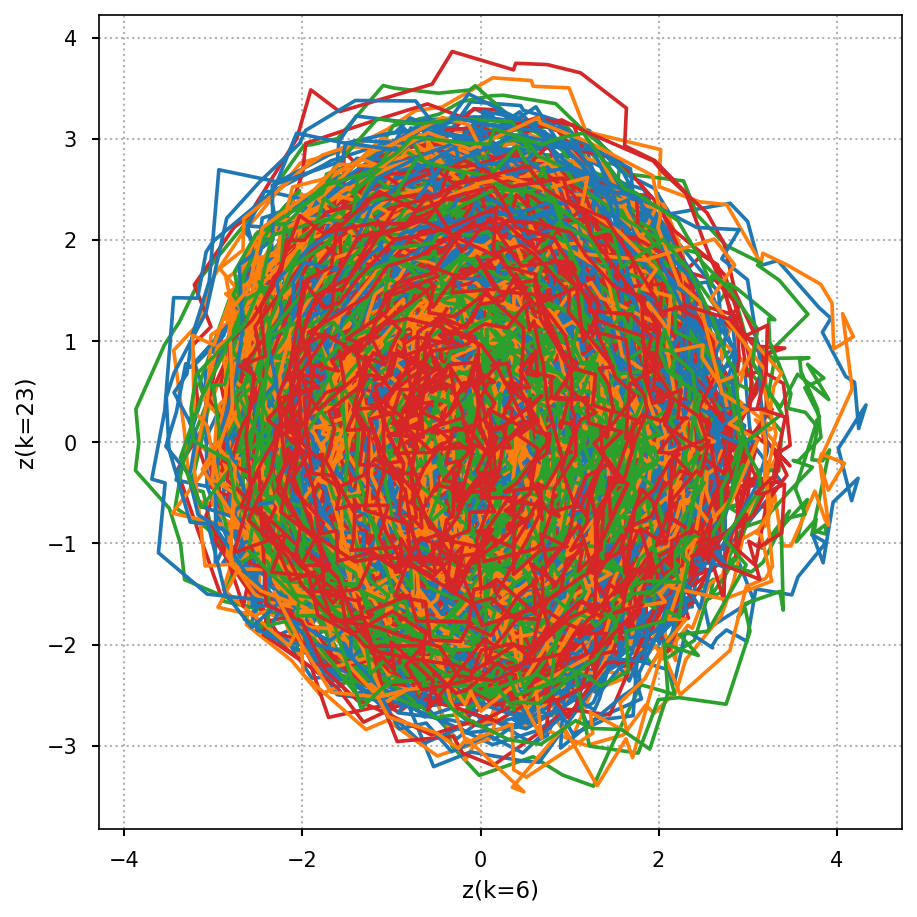

In [68]:
k0, k1 = k_pair

fig, ax = plt.subplots(1, figsize=(FIGWIDTH * 0.5, FIGWIDTH * 0.5))
for dataset_name, forcing, z in zip(dataset_names_rand[validation_split:], forcing_data[validation_split:],
                                    z_sample_list):
    forcing = np.atleast_2d(forcing)[:, 0] / params.forcing.get('scale', 1)
    ax.plot(z[:, k0].reshape(-1, r).mean(axis=-1),
            z[:, k1].reshape(-1, r).mean(axis=-1),
            linestyle='-',
            color=color_dict[dataset_name])

ax.set_xlabel(f'z(k={k0})')
ax.set_ylabel(f'z(k={k1})')
ax.grid(linestyle=':')

We see that the distributions of the $z$ values have a strong overlap, indicating success of the VAE in learning an invariant representation of the oscillatory dynamics as well.

## Model output

We first obtain the model outputs from the input data given to `val_gen`.

In [69]:
xcs, ycs = model.predict(val_gen, verbose=VERBOSE)

The `decoder` and `prediction` outputs, `xcs` and `ycs`, are concatenated along the lag/lead dimension and the singleton dimension for `set_size=1` is removed.

In [70]:
xcs = np.concatenate([xcs, ycs], axis=2)
xcs = np.squeeze(xcs, axis=1)

The model output is split into the different model runs.

In [71]:
xcs_list = np.split(xcs, val_gen_splits, axis=0)

Then, the model output is aligned with the target month and split into the different variables. To reduce the later size of the netCDF files, we restrict the VAE output to specific time lags given in `export_lags`.

In [72]:
export_lags = [-1]
# export_lags = np.arange(-val_gen.input_length, val_gen.prediction_length)

In [73]:
channel_splits = np.cumsum(variable_channels)
level = np.arange(-val_gen.input_length, val_gen.prediction_length)
lag_idx = val_gen.input_length + np.array(export_lags)

level = level[lag_idx]

r = val_gen.repeat_samples
xcs_variables = {}
xcs_dimensions = {}
xcs_attributes = {}
for dataset_name, values, t in zip(dataset_names_rand[validation_split:], xcs_list, time[validation_split:]):
    # restrict to given time lags
    values = values[:, lag_idx, :]
    # average over repeat samples
    values = values.reshape(-1, r, *values.shape[1:]).mean(axis=1)
    # align  with target month
    values = np.pad(values, ((val_gen.input_length, val_gen.prediction_length - 1), (0, 0), (0, 0)),
                    mode='constant',
                    constant_values=np.nan)
    values = np.stack([np.roll(values[:, n, :], lag, axis=0) for n, lag in enumerate(level)], axis=1)
    # split channels into variables
    splits = np.split(values, channel_splits, axis=-1)

    xcs_variables[dataset_name] = dict(zip(variable_names, splits))
    xcs_dimensions[dataset_name] = {variable_name: {'time': t, 'level': level} for variable_name in variable_names}
    xcs_attributes[dataset_name] = {
        variable_name: {
            'level': {
                'long_name': 'Time lag',
                'units': '',
                'axis': 'Z'
            }
        }
        for variable_name in variable_names
    }

In the following plot, we show examples of the model output.

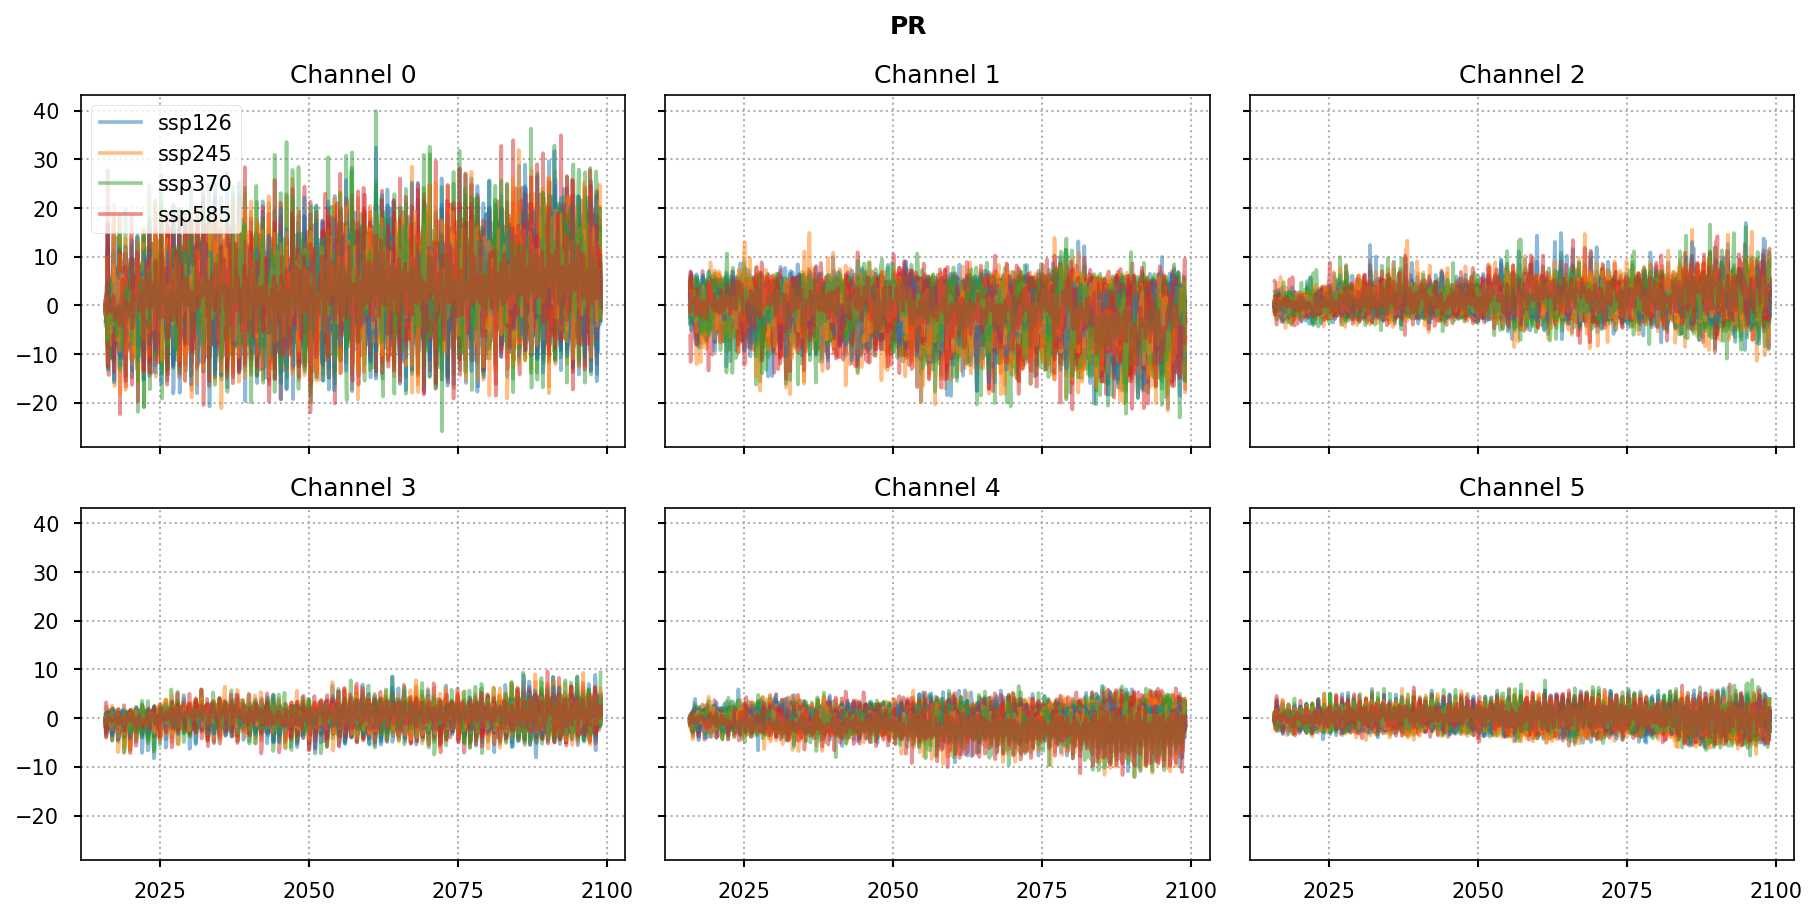

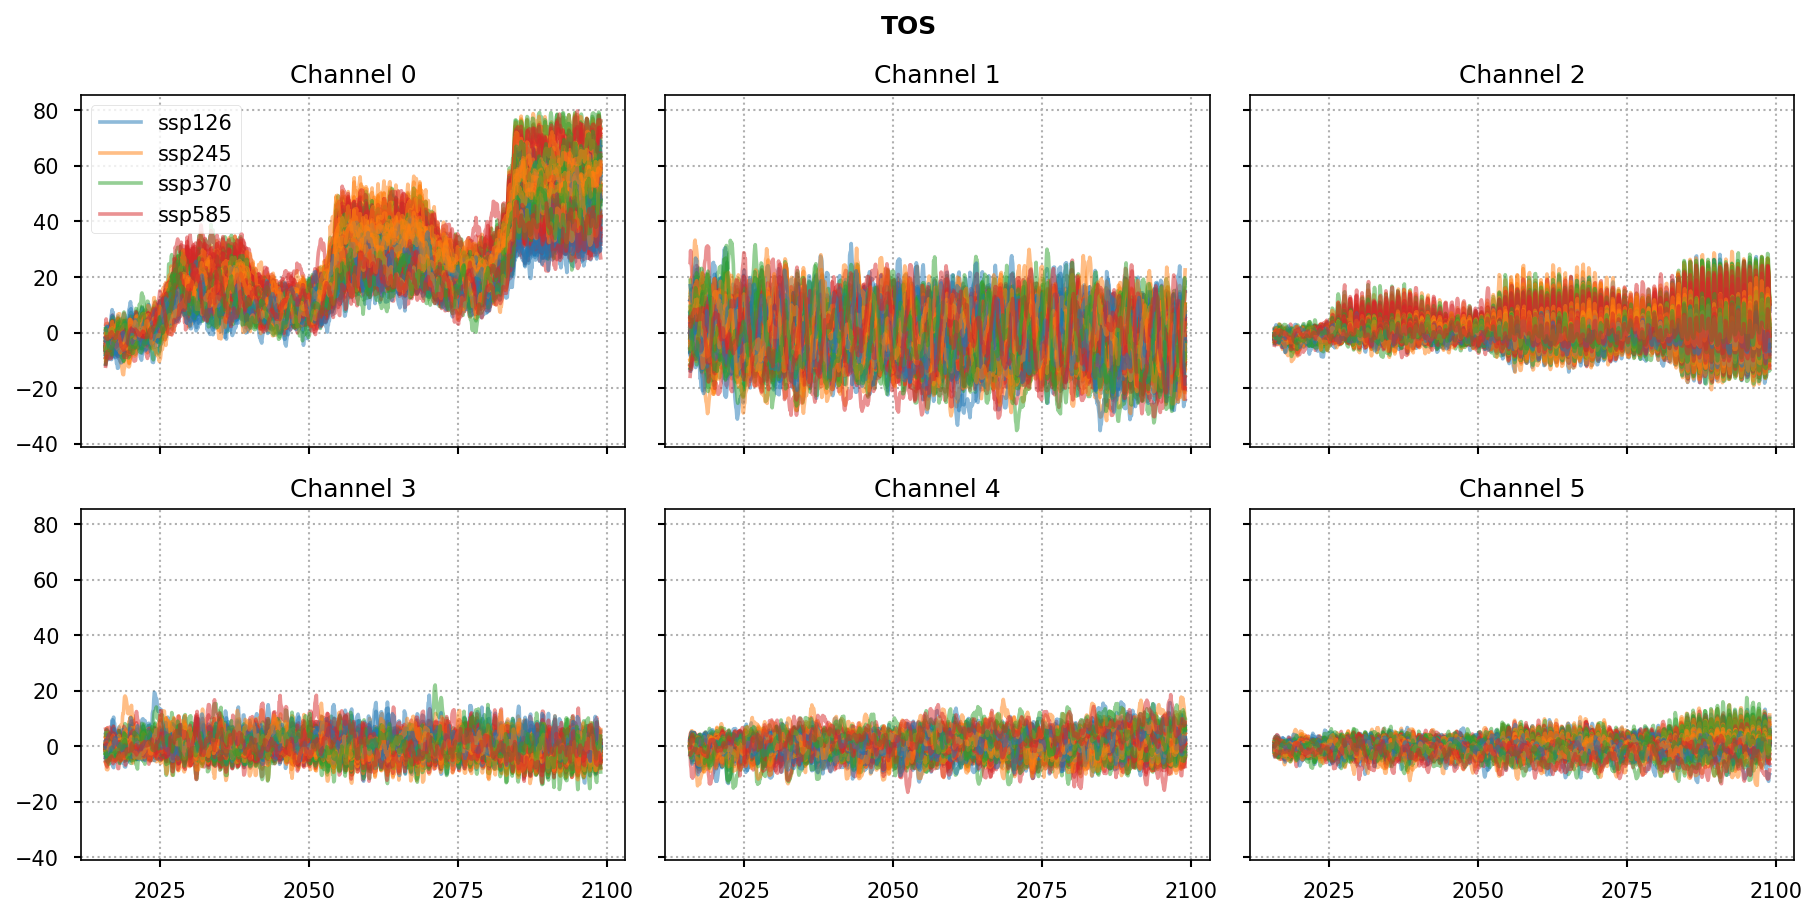

In [79]:
lag_idx = np.searchsorted(export_lags, -1)
cols = 3
rows = 2

for variable_name in variable_names:
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(FIGWIDTH, 3 * rows), squeeze=False)
    fig.suptitle(variable_name.upper(), fontweight='bold')
    for idx, dataset_name in enumerate(dataset_names_rand[validation_split:]):
        for channel, (ax, values) in enumerate(zip(axs.flat, xcs_variables[dataset_name][variable_name].T)):
            label = dataset_name[1] if idx in first_idx else None
            ax.plot(xcs_dimensions[dataset_name][variable_name]['time'],
                    values.T[:, lag_idx],
                    color=color_dict[dataset_name],
                    label=label,
                    alpha=0.5)

            ax.set_title(f'Channel {channel}')
            ax.grid(visible=True, linestyle=':')
            locator = dates.YearLocator(25)
            ax.xaxis.set_major_formatter(dates.ConciseDateFormatter(locator))
            ax.xaxis.set_major_locator(locator)

    axs.flat[0].legend()

Since the decoder is provided with a different CO2 concentration scenario than the one used for the encoder, the decoder output differs from the input data to the encoder. Instead, the decoder output provides a forecast for the given CO2 concentration scenario.

## Reconstruction in grid space

In the following, the model output is projected into the grid space by forming the scalar product of the model output with the EOFs. The reults are exported as netCDF files.

### Load EOFs

First, we load the EOFs from the `eofs.nc` files, which can also be found in the data folders.

In [53]:
eof_files = [os.path.join(os.path.dirname(filename), 'eofs.nc') for filename in params.data['filename']]
_eof_variables, _eof_dimensions, _eof_attributes = fileio.read_netcdf_multi(filename=eof_files,
                                                                            time_range=params.data.get('level_range'),
                                                                            dtype=params.data.get('dtype'))

data\cmip6\ssp\pr\pcs\eofs.nc  : 1 file(s) found.
data\cmip6\ssp\tos\pcs\eofs.nc : 1 file(s) found.
2/2 [==============================] - 0s 16ms/file


In [54]:
eof_variables = {}
eof_dimensions = {}
eof_attributes = {}
for dataset_name, values in _eof_variables.items():
    eof_variables |= values

    eof_dimensions |= {k: _eof_dimensions[dataset_name] for k in values}
    eof_attributes |= {k: _eof_attributes[dataset_name] for k in values}

### Load climatological mean

To obtain absolute values, we also load the corresponding climatological mean fields. The netCDF files will be looked up in the folder `mean_path`, relative to the data folder.

In [55]:
mean_path = '../mean/*.nc'
mean_files = [os.path.join(os.path.dirname(filename), mean_path) for filename in params.data['filename']]
_mean_variables, _mean_dimensions, _mean_attributes = fileio.read_netcdf_multi(filename=mean_files,
                                                                               num2date=True,
                                                                               dtype=params.data.get('dtype'))

data\cmip6\ssp\pr\mean\*.nc  : 100 file(s) found.
data\cmip6\ssp\tos\mean\*.nc : 100 file(s) found.
200/200 [==============================] - 3s 14ms/file


We group the netCDF files and their variables by the global attributes `source_id` + `experiment_id`, as for the CMIP data.

In [56]:
mean_variables = {}
mean_dimensions = {}
mean_attributes = {}

key1 = 'source_id'
key2 = 'experiment_id'
for dataset_name, values in _mean_variables.items():
    target_key = (
        _mean_attributes[dataset_name]['.'][key1],
        _mean_attributes[dataset_name]['.'][key2],
    )

    mean_variables.setdefault(target_key, {})
    mean_dimensions.setdefault(target_key, {})
    mean_attributes.setdefault(target_key, {})

    mean_variables[target_key] |= values
    mean_dimensions[target_key] |= {k: _mean_dimensions[dataset_name] for k in values}
    mean_attributes[target_key] |= {k: _mean_attributes[dataset_name] for k in values}

### Select model runs

We restrict the export of netCDF files to model runs with highest KL divergence, i.e. the model runs that are most important in the construction of the aggregated posterior. We exclude the low-frequency component from the calculation of the mean KL divergence.

In [57]:
topk = 5

In [58]:
kl_div_list = np.split(kl_div, val_gen_splits, axis=0)
k = list(set(z_order) - set([k_trend]))
# k = z_order
kl_div_mean = np.array([kl[:, k].mean() for kl in kl_div_list])

In [59]:
source_ids, experiment_ids = list(zip(*dataset_names_rand))

df = pd.DataFrame({'source_id': source_ids, 'experiment_id': experiment_ids, 'KL div': kl_div_mean})
df = df.pivot(values='KL div', index='source_id', columns='experiment_id')
mean = df.mean(axis=1).sort_values(ascending=False)
df = df.reindex(mean.index)

display(
    df.style.background_gradient(
        'coolwarm',
        text_color_threshold=0,
        axis=0,
    ).highlight_quantile(
        axis=0,
        q_left=(len(df) - topk) / len(df),
        props='font-weight:900',
    ).format(precision=2))

The table shows the KL divergence averaged over the different model runs. In each scenario, we select the `topk` model runs with the highest KL divergence (in bold).

In [60]:
dataset_names_topk = []
for column in df:
    names = df[column].dropna().sort_values(ascending=False).iloc[:topk].index.tolist()
    dataset_names_topk += [(name, column) for name in names]

### Export to netCDF

We form the dot product of the selected model outputs with the EOFs and add the climatological mean. Optionally, the log transform is reverted. The result is then written to netCDF files in the folder initially given in `EXPORT_DIR`.

In [61]:
os.makedirs(EXPORT_DIR, exist_ok=True)

In [62]:
sup_time = np.unique(np.concatenate(time).astype('datetime64[M]'))

for variable_name in variable_names:
    print('-' * 3, variable_name, '-' * (77 - len(variable_name)))
    filename = '{prefix:s}' + variable_name + '.{type:s}.nc'
    filename = os.path.join(EXPORT_DIR, filename)

    # align model outputs
    values = []
    for dataset_name in dataset_names_topk:
        _value = xcs_variables[dataset_name][variable_name]
        _time = xcs_dimensions[dataset_name][variable_name]['time'].to_numpy().astype('datetime64[M]')
        idx = np.isin(sup_time, _time, assume_unique=True)
        value = np.full_like(_value, np.nan, shape=(len(sup_time), *_value.shape[1:]))
        value[idx, ...] = _value

        values.append(value)
        nc_dimensions = mean_dimensions[dataset_name][variable_name] | dimensions[dataset_name][
            variable_name] | xcs_dimensions[dataset_name][variable_name]
        nc_attributes = mean_attributes[dataset_name][variable_name] | attributes[dataset_name][
            variable_name] | xcs_attributes[dataset_name][variable_name]

    values = np.stack(values)
    # scalar product
    nc_variables = np.tensordot(values, eof_variables[variable_name], axes=1)

    nc_dimensions['time'] = sup_time
    kwargs = dict(dimensions=nc_dimensions, attributes=nc_attributes)

    # save anomalies
    fileio.write_netcdf(filename.format(prefix='anom_', type='ensmean'),
                        variables={variable_name: np.mean(nc_variables, axis=0)},
                        **kwargs)

    prcs = {'ensmedian': 50, 'enspctl10': 10, 'enspctl90': 90}
    nc_prcs = np.percentile(nc_variables, list(prcs.values()), axis=0)
    for type, value in zip(prcs, nc_prcs):
        fileio.write_netcdf(filename.format(prefix='anom_', type=type), variables={variable_name: value}, **kwargs)

    # revert to absolute values
    months = pd.to_datetime(nc_dimensions['time']).month
    for nc_variable, dataset_name in zip(nc_variables, dataset_names_topk):
        mean_months = pd.to_datetime(mean_dimensions[dataset_name][variable_name]['time']).month
        for month in mean_months:
            nc_variable[months == month, ...] += mean_variables[dataset_name][variable_name][mean_months == month, ...]

    # invert log transform
    if '-log ' in nc_attributes['.']['history']:
        nc_variables = np.exp(nc_variables)

    # save absolute values
    fileio.write_netcdf(filename.format(prefix='', type='ensmean'),
                        variables={variable_name: np.mean(nc_variables, axis=0)},
                        **kwargs)

    nc_prcs = np.percentile(nc_variables, list(prcs.values()), axis=0)
    for type, value in zip(prcs, nc_prcs):
        fileio.write_netcdf(filename.format(prefix='', type=type), variables={variable_name: value}, **kwargs)

--- pr ---------------------------------------------------------------------------
Write: results\2023-05-30T18.58\anom_pr.ensmean.nc
Write: results\2023-05-30T18.58\anom_pr.ensmedian.nc
Write: results\2023-05-30T18.58\anom_pr.enspctl10.nc
Write: results\2023-05-30T18.58\anom_pr.enspctl90.nc
Write: results\2023-05-30T18.58\pr.ensmean.nc
Write: results\2023-05-30T18.58\pr.ensmedian.nc
Write: results\2023-05-30T18.58\pr.enspctl10.nc
Write: results\2023-05-30T18.58\pr.enspctl90.nc
--- tos --------------------------------------------------------------------------
Write: results\2023-05-30T18.58\anom_tos.ensmean.nc
Write: results\2023-05-30T18.58\anom_tos.ensmedian.nc
Write: results\2023-05-30T18.58\anom_tos.enspctl10.nc
Write: results\2023-05-30T18.58\anom_tos.enspctl90.nc
Write: results\2023-05-30T18.58\tos.ensmean.nc
Write: results\2023-05-30T18.58\tos.ensmedian.nc
Write: results\2023-05-30T18.58\tos.enspctl10.nc
Write: results\2023-05-30T18.58\tos.enspctl90.nc
